# Class 22: Network Sampling

Goal of today's class:
1. Define what network sampling means in theory and practice
2. Introduce biases that emerge when sampling networks
3. Highlight several key sampling approaches

*Acknowledgement: This lesson is based on material created by Matteo Chinazzi and Qian Zhang in a previous version of this course.*
__________

1. Come in. Sit down. Open Teams.
2. Find your notebook in your /Class_22/ folder.
________

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('axes', axisbelow=True)
rc('axes', fc='w')
rc('figure', fc='w')
rc('savefig', fc='w')

## Why sample networks?

Up to now in the course we've mostly treated the network as if it were "the" system: someone hands us an adjacency matrix or an edge list, and our job is to analyze it. In almost every real application, though, that observed graph is itself the product of a **sampling process**. We only see some people and not others, some interactions and not others, some parts of the infrastructure and not others. Thinking carefully about *how* a network was sampled—and about whether we want to intentionally sample it differently—is central to making valid inferences from network data.

There are at least three broad reasons why sampling is unavoidable:

1. Many networks are too large, dynamic, or restricted **to observe in full**. Online social networks, the Web, or Internet router-level topologies are measured through APIs, logs, and traceroute-like probes that capture only a subset of nodes and links. Internet mapping projects, for example, send probes from a limited set of sources to many destinations and reconstruct a router-level map from the union of those paths; by construction this is a *sampled* view of the underlying topology, and it can be heavily biased toward high-degree routers and frequently used routes. 

    Classic work on traceroute sampling shows that even if the underlying network is relatively homogeneous, the sampled view can look much more heavy-tailed or hierarchical than it really is. In neuroscience, we often record activity from a small subset of neurons or brain regions and treat that as a proxy for the full functional connectivity network. In transportation and mobility, we might see only trips from a subset of apps, cell towers, or ticketing systems, and infer a larger mobility network from partial traces.

2. Second, even when a full network exists somewhere, practical constraints often force **intentional subsampling**. Large social, information, or biological networks can contain millions or billions of nodes and edges; storing and processing the full graph may be prohibitively expensive, especially in streaming or online settings. This has motivated a large literature on graph sampling for data mining: selecting a smaller subgraph that approximately preserves degree distributions, clustering, community structure, motif counts, or distances, so that downstream algorithms can run on the sample instead of the full network.

    Work on sampling from large graphs shows that different sampling schemes (node-based, edge-based, exploration-based) vary in how well they preserve statistics like diameter, degree distribution, and clustering, and introduces ideas like scaled-down or coarse-grained graphs (match a smaller network) or back-in-time graphs (match an earlier snapshot of a growing graph). More recent papers extend this to *streaming* settings, where the graph is observed as a sequence of edges and the sampling algorithm has strict memory and one-pass constraints.


3. Third, in many domains **the only way to collect data at all is through link-tracing or chain-referral sampling**. Hidden or hard-to-reach populations—such as people who inject drugs, sex workers, or some migrant communities—are often studied through snowball or *respondent-driven* sampling, where participants recruit their contacts into the study. Here, the network is not just a sampling application; the *mechanism* behind the network itself is a walk or branching process on the social network, and the dependence structure of the sample paths strongly affects estimators.

    Methods like Network Sampling with Memory explicitly exploit network structure and respondents' local knowledge to reduce design effects and improve efficiency. Similar link-tracing designs appear in epidemiological contact tracing (following chains of infection), and in measurements of online social networks, where API rate limits or platform restrictions force us to crawl along edges rather than enumerate all nodes.

_________

Some common sampling procedures:

- **Induced subgraph sampling** (sample nodes uniformly, keep all edges between them),
- **Incident (or ego-centered) subgraph sampling** (sample nodes and keep edges incident to them),
- **Snowball / link-tracing sampling** (start from seeds and iteratively add neighbors),
- **Random-walk sampling** (move step by step along edges according to a Markov chain),
- **More advanced algorithms** such as random walks with jumps, Metropolis-Hastings walks, or noise-corrected topological sampling for online social networks.

___________

## Network Sampling Formalism

To formalize this, it helps to imagine a (usually unobserved) **population graph** $G = (V, E)$ and an observed **sampled graph** $G_s = (V_s, E_s)$. Under a given sampling approach, each node $i \in V$ has some *inclusion probability* $\pi_i$, and each edge $e_{ij} \in E$ has an inclusion probability $\pi_{ij}$. A central theme in the theory papers on network sampling is: when do the distributions of key statistics in $G_s$ belong to the same "family" as in $G$? For example, work on subgraphs of scale-free networks and on the statistical properties of sampled networks shows that:

- even if the full network has a clean power-law degree distribution, many common sampling schemes produce samples that are *not* scale-free, or that have apparent exponents very different from the truth;
- different sampling strategies (random node sampling, degree-biased sampling, BFS-like exploration, etc.) can systematically distort degree distributions, assortativity, path lengths, betweenness, and clustering in different ways.

A ***descriptor*** of the graph $G$ is denoted by $\Phi (G)$ (remember Chapter 19 on Graph Distances). $\Phi (G)$ can be a _point statistic_ such as the average degree of the nodes in $V$ or the global clustering coefficient of the graph, or a _distribution_ such as the degree distribution or the clustering distribution, etc.

In other words, many familiar network statistics—degree, clustering, centrality, community structure—can be dramatically distorted by the sampling method. Different approaches produce systematically different views of the same underlying graph. This matters not just for descriptive analysis, but also for **inference and comparison**: for example, comparing two large networks via sub-sampling strategies, or training a classifier on sampled networks and asking whether performance reflects the underlying topology or the sampling artifacts.


In this chapter we will lean into this perspective: instead of treating the adjacency matrix as a given object, we will treat the observed network as the output of a sampling design applied to some (usually unknown) underlying graph. We will look at several common designs—node-based, edge-based, and topology-based samplers—and see how each one selects different parts of the graph, how it biases standard network statistics, and how we can sometimes correct for those biases. The goal is not to turn everyone into a survey statistician, but to make it hard to look at a network dataset again without asking: *what sampling process produced this graph, and what does that imply for the conclusions I'm about to draw?*

______

## To start class: A challenge!

In 2005, an influential (and short) paper was published, showing that subgraphs of scale-free networks are not necessarily scale-free.

**Source:** Stumpf, M. P., Wiuf, C., & May, R. M. (2005). Subnets of scale-free networks are not scale-free: sampling properties of networks. *Proceedings of the National Academy of Sciences*, 102(12), 4221-4224. https://www.pnas.org/doi/full/10.1073/pnas.0501179102

![](images/subnets.png)

___________

The authors used the following sampling procedure (left), and showed that randomly sampling a (e.g.) Barabasi-Albert graph at $p=0.2$ and $p=0.8$ densities produces degree distributions that appear not to be scale-free.

![](images/subnet_result.png)
_______

Let's reproduce this result, in stages. What ingredients do we need to reproduce this figure?

In [2]:
pass

__________

1. Generate a BA network (of large enough size to observe the finding)
2. Measure and plot its degree distribution
3. Create a sampling algorithm, according to Fig. 1 above
4. Sample a graph, G_s, from G, based on $p=0.2$ of the nodes
5. Plot the degree distribution G_s

In [3]:
# 1. 
N = 1_000_000
m = 2

G = nx.barabasi_albert_graph(N, m)

In [4]:
def get_binning(data, num_bins=40, is_pmf=False, log_binning=False, threshold=0):
    """
    Bins the input data and calculates the probability mass function (PMF) or 
    probability density function (PDF) over the bins. Supports both linear and 
    logarithmic binning.

    Parameters
    ----------
    data : array-like
        The data to be binned, typically a list or numpy array of values.
    num_bins : int, optional
        The number of bins to use for binning the data (default is 15).
    is_pmf : bool, optional
        If True, computes the probability mass function (PMF) by normalizing 
        histogram counts to sum to 1. If False, computes the probability density 
        function (PDF) by normalizing the density of the bins (default is True).
    log_binning : bool, optional
        If True, uses logarithmic binning with log-spaced bins. If False, uses 
        linear binning (default is False).
    threshold : float, optional
        Only values greater than `threshold` will be included in the binning, 
        allowing for the removal of isolated nodes or outliers (default is 0).
    
    Returns
    -------
    x : numpy.ndarray
        The bin centers, adjusted to be the midpoint of each bin.
    p : numpy.ndarray
        The computed PMF or PDF values for each bin.
    
    Notes
    -----
    This function removes values below a specified threshold, then defines 
    bin edges based on the specified binning method (linear or logarithmic). 
    It calculates either the PMF or PDF based on `is_pmf`.
    """
    
    # Filter out isolated nodes or low values by removing data below threshold
    values = list(filter(lambda x: x > threshold, data))
#     if len(values) != len(data):
#         print("%s isolated nodes have been removed" % (len(data) - len(values)))

    # Define the range for binning (support of the distribution)
    lower_bound = min(values)
    upper_bound = max(values)

    # Define bin edges based on binning type (logarithmic or linear)
    if log_binning:
        # Use log-spaced bins by taking the log of the bounds
        lower_bound = np.log10(lower_bound)
        upper_bound = np.log10(upper_bound)
        bin_edges = np.logspace(lower_bound, upper_bound, num_bins + 1, base=10)
    else:
        # Use linearly spaced bins
        bin_edges = np.linspace(lower_bound, upper_bound, num_bins + 1)

    # Calculate histogram based on chosen binning method
    if is_pmf:
        # Calculate PMF: normalized counts of data in each bin
        y, _ = np.histogram(values, bins=bin_edges, density=False)
        p = y / y.sum()  # Normalize to get probabilities
    else:
        # Calculate PDF: normalized density of data in each bin
        p, _ = np.histogram(values, bins=bin_edges, density=True)

    # Compute bin centers (midpoints) to represent each bin
    x = bin_edges[1:] - np.diff(bin_edges) / 2  # Bin centers for plotting

    # Remove bins with zero probability to avoid plotting/display issues
    x = x[p > 0]
    p = p[p > 0]

    return x, p

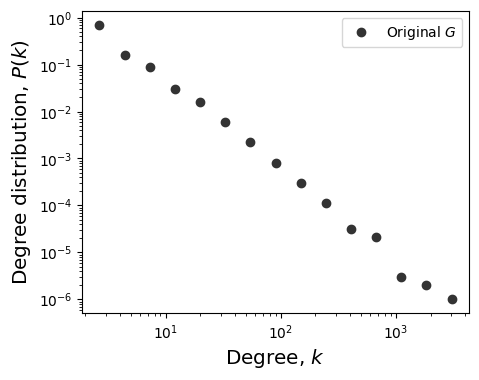

In [5]:
# 2. Plot degree distribution of G
fig, ax = plt.subplots(1,1,figsize=(5,4),dpi=100)
plt.subplots_adjust(wspace=0.25)

x, y = get_binning(list(dict(G.degree()).values()),
                   num_bins=15, log_binning=True, is_pmf=True)

ax.loglog(x,y,'o',color='.2', label=r'Original $G$')
ax.set_ylabel(r'Degree distribution, $P(k)$',fontsize='x-large')
ax.set_xlabel(r'Degree, $k$',fontsize='x-large')

# p = 0.2
# G_s02 = sample_subgraph_random_nodes(G, p, seed=9)
# x_s02, y_s02 = get_binning(list(dict(G_s02.degree()).values()),
#                    num_bins=15, log_binning=True, is_pmf=True)

# ax.loglog(x_s02,y_s02,'s',color='palevioletred', label=r'$G_s$ (p=0.2)',mec='.9')

# p = 0.8
# G_s08 = sample_subgraph_random_nodes(G, p, seed=9)
# x_s08, y_s08 = get_binning(list(dict(G_s08.degree()).values()),
#                    num_bins=15, log_binning=True, is_pmf=True)

# ax.loglog(x_s08,y_s08,'s',color='crimson', label=r'$G_s$ (p=0.8)',mec='.9')


ax.legend()


plt.show()

### Your turn: Create a function to create G_s as described in Fig. 1 above

In [6]:
# 3. YOUR TURN!

def sample_subgraph_random_nodes(G, p=0.2):
    """
    Random node sampling:
      - keep each node independently with probability p
      - return the induced subgraph on the kept nodes, G_s
    """

    pass
    
    
    return G_s

In [7]:
pass

you have 5 minutes

____________

In [8]:
def sample_subgraph_random_nodes(G, p, seed=None):
    """
    Random node sampling:
      - keep each node independently with probability p
      - return the induced subgraph on the kept nodes
    """
    rng = np.random.default_rng(seed)
    nodes = [n for n in G.nodes if rng.random() < p]
    return G.subgraph(nodes).copy()

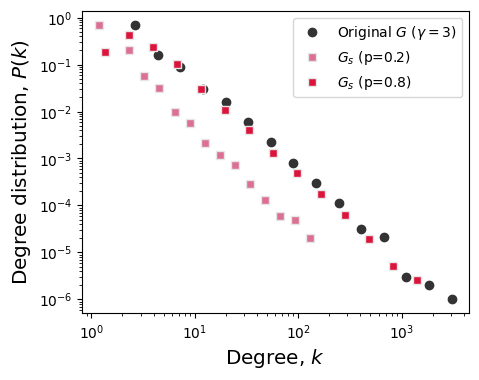

In [9]:
# 2. Plot degree distribution of G
fig, ax = plt.subplots(1,1,figsize=(5,4),dpi=100)
plt.subplots_adjust(wspace=0.25)

x, y = get_binning(list(dict(G.degree()).values()),
                   num_bins=15, log_binning=True, is_pmf=True)

ax.loglog(x,y,'o',color='.2', label=r'Original $G$ ($\gamma=3$)')
ax.set_ylabel(r'Degree distribution, $P(k)$',fontsize='x-large')
ax.set_xlabel(r'Degree, $k$',fontsize='x-large')

p = 0.2
G_s02 = sample_subgraph_random_nodes(G, p, seed=9)
x_s02, y_s02 = get_binning(list(dict(G_s02.degree()).values()),
                   num_bins=15, log_binning=True, is_pmf=True)

ax.loglog(x_s02,y_s02,'s',color='palevioletred', label=r'$G_s$ (p=0.2)',mec='.9')

p = 0.8
G_s08 = sample_subgraph_random_nodes(G, p, seed=9)
x_s08, y_s08 = get_binning(list(dict(G_s08.degree()).values()),
                   num_bins=15, log_binning=True, is_pmf=True)

ax.loglog(x_s08,y_s08,'s',color='crimson', label=r'$G_s$ (p=0.8)',mec='.9')


ax.legend()


plt.show()

Still to do, on your own time: Measure the degree exponent of $G_s$

_________

## Classes of Sampling Methods
1. ***Node Selection***: a subset of nodes is sampled;
2. ***Edge Selection***: a subset of edges is sampled;
2. ***Topology-based Sampling*** (exploration sampling): the topology of the population graph is used to extract the sampled graph.

____________
Final note: a lot of the motivation behind this chapter comes from the (phenomenal) book, specifically Chapter 5:
- Kolaczyk, E. D. (2009). Sampling and estimation in network graphs. In Statistical Analysis of Network Data: Methods and Models (pp. 1-30). New York, NY: Springer New York. https://link.springer.com/book/10.1007/978-0-387-88146-1

![](images/kolaczyk.png)

___________

## Method 1: Induced Subgraph Sampling

![](images/induced_subgraph_sampling.png)



***Induced subgraph sampling*** consists in drawing at random $n$ vertices from a graph of size $N$. In particular, let us denote with $G = (V,E)$ the original graph and with $G_s = (V_s,E_s)$ the sampled subgraph. Then, the set $V_s$ includes the $n$ nodes randomly drawn from $V$ and $E_s$ contains all the edges $e_{i,j}$ such that both $i$ and $j$ belong to $V_s$.

In this case, the _vertex inclusion probability_ is equal to $\pi_i = \frac{n}{N_v};$ while the _edge inclusion probability_ is equal to $ \pi_{e_{i,j}} = \frac{n(n-1)}{N(N-1)}$, $\forall i \in V$, and $\forall e_{i,j} \in E$.

#### Vertex inclusion probability - proof

Given that our sample size is $n$, we can extract up to $\binom{N}{n}$ different samples if we do not impose any contraint on whether or not a specific node is selected. However, if we do impose that node $i$ has to be included, then the total number of possible samples becomes $\binom{N-1}{n-1}$.

Therefore, the vertex inclusion probability of a generic node $i$ is:
$$ \pi_i = \frac{\binom{N-1}{n-1}}{\binom{N}{n}} = \frac{\frac{(N-1)!}{(n-1)!(N-n)!}}{\frac{N!}{n!(N-n)!}} = \frac{(N-1)!}{(n-1)!} \frac{n!}{N_v!} = \frac{n}{N_v} $$

In [10]:
N = 1000
M = 50000
average_degree = 2*M/N
print(average_degree)

p = average_degree/(N-1)
G_er = nx.erdos_renyi_graph(N,p)
G_ws = nx.watts_strogatz_graph(N, int(average_degree), p=0.01)

print("Average degree ER:", np.mean(list(dict(G_er.degree()).values())))
print("Average degree WS:",  np.mean(list(dict(G_ws.degree()).values())))

100.0
Average degree ER: 99.908
Average degree WS: 100.0


In [11]:
from numpy.random import choice

In [12]:
def induced_subgraph_sampling(G, n):
    """
    Samples an induced subgraph of `n` nodes from the input graph `G`.
    
    Parameters
    ----------
    G : networkx.Graph
        The input graph from which the subgraph is sampled.
    n : int
        The number of nodes to include in the sampled induced subgraph.
    
    Returns
    -------
    subgraph : networkx.Graph
        The induced subgraph with `n` nodes and the edges among them.
        
    Raises
    ------
    ValueError
        If `n` is larger than the number of nodes in the graph.
    """
    # Ensure `n` is not larger than the number of nodes in G
    if n > G.number_of_nodes():
        raise ValueError("`n` must be less than or equal to the number of nodes in the graph.")
    
    # Get the list of nodes in the graph
    nodes = list(G.nodes())
    
    # Randomly sample `n` nodes without replacement
    sampled_nodes = np.random.choice(nodes, size=n, replace=False)
    
    # Create an induced subgraph of G using the sampled nodes
    subgraph = G.subgraph(sampled_nodes).copy()
    
    return subgraph

In [13]:
pos = nx.circular_layout(G_ws)

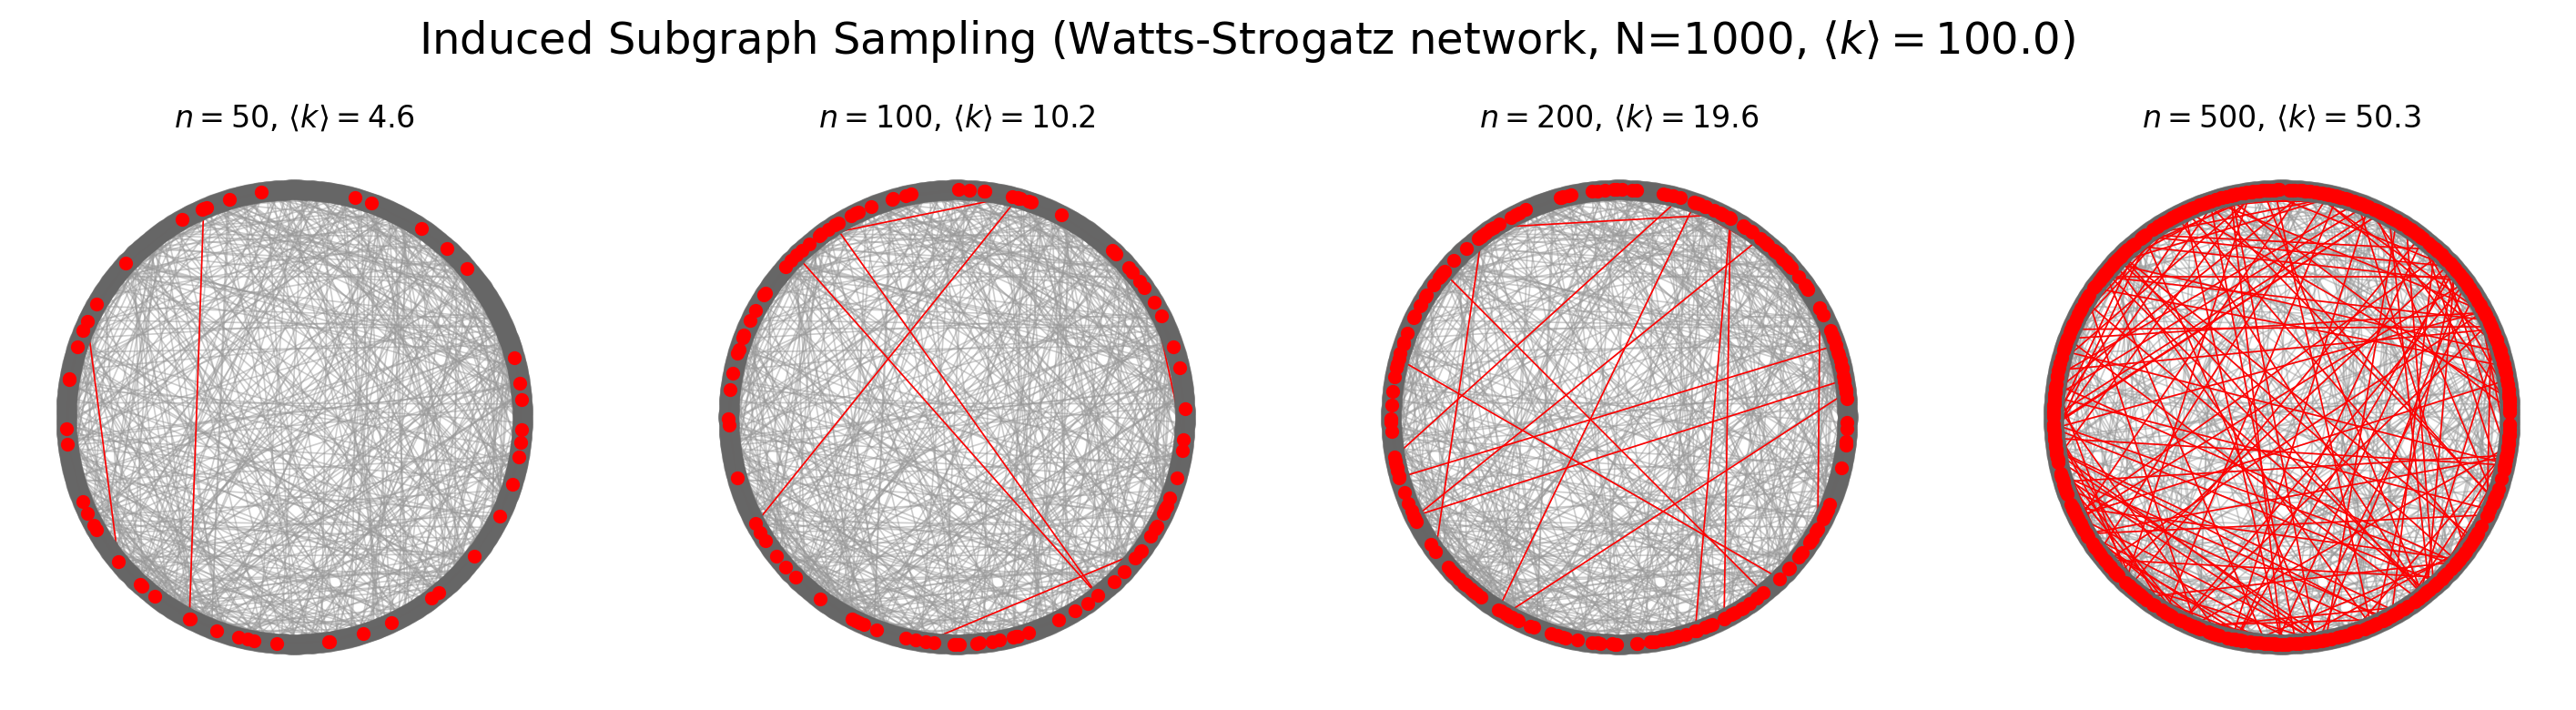

In [14]:
fig, ax = plt.subplots(1,4,figsize=(18,4),dpi=200)

for ni,n in enumerate([50,100,200,500]):
    subg = induced_subgraph_sampling(G_ws, n)
    nx.draw(G_ws, pos, node_color='.4', node_size=50, alpha=0.5, edge_color='.6', width=0.6, ax=ax[ni])
    nx.draw(subg, pos, node_color='red',node_size=20, edge_color='red', width=0.6, ax=ax[ni])
    ax[ni].set_title(r'$n = %i$, $\langle k \rangle = %.1f$'%(n, np.mean(list(dict(subg.degree).values()))))

plt.suptitle(r'Induced Subgraph Sampling (Watts-Strogatz network, N=%i, $\langle k \rangle = %.1f$)'%(
    G_ws.number_of_nodes(),average_degree),
             y=1.05, fontsize='xx-large')
plt.show()

### Statistics note: The Horvitz-Thompson Estimator

Let $U$ be a population of size $N$ (e.g. Facebook users, Twitter users, etc..) and let $y_i$ be a variable of interest associated to each individual $i$ in the population $U$ (e.g. number of friends, number of followers, etc..). Let us denote with $\tau$ the total and with $\mu$ the average of the $y_i$'s values, i.e. $\tau = \sum_i y_i$ and $\mu = \tau/N$. Let us also denote with $S$ a sample of $n$ units from population $N$ and assume that for each unit $i$ in sample $S$ we observe the value $y_i$. Then, we can use the ***Horvitz-Thompson estimator*** to estimate the value of $\tau$ and $\mu$ from the random sample $S$:

$$ \hat{\tau}_\pi = \sum_{i \in S} \frac{y_i}{\pi_i} ,$$

$$ \hat{\mu}_\pi = \frac{\hat{\tau}_\pi }{N} ,$$

where $\pi_{i}$ denotes the _inclusion probability_ of unit $i$ in the sample $S$.

___________

#### Estimate the average degree of the graph from the sampled graph

To estimate $M$ we can use the ***Horvitz-Thompson estimator***:
1. Our individual $i$ is the edge $e_{i,j}$ 
2. The total we want to estimate is: $\tau = M =  \sum_i y_i = \sum_{e_{i,j}}1$
3. In our case, the edge inclusion probability is: $ \pi_{e_{i,j}} = \frac{n(n-1)}{N_v(N_v-1)} ,$
4. Therefore we can estimate $\hat{M}$ as: $ \hat{\tau}_\pi = \sum_{e_{i,j} \in S} \frac{1}{\pi_{e_{i,j}}} = M_s\frac{N_v(N_v-1)}{n(n-1)}$

Then, we can compute $\hat{k}$ as: $\hat{k} = \frac{2\hat{M}}{N}$.

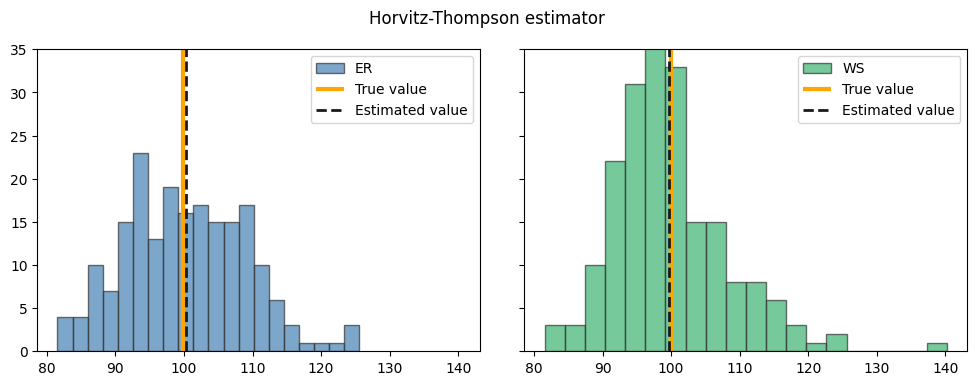

In [15]:
fig, ax = plt.subplots(1,2,figsize=(12,4),dpi=100,sharey=True,sharex=True)
plt.subplots_adjust(wspace=0.1)
cols = ['steelblue','mediumseagreen']
    
B = 200 # number of simulations
labels = ['ER','WS']
for a, G in enumerate([G_er, G_ws]):
    av_degs = np.zeros(B)
    for b in range(B):
        n = 50
        subg_G = induced_subgraph_sampling(G, n)
        m = subg_G.number_of_edges()
        prob_e = n*(n-1)/N/(N-1)
        M_est = m/prob_e
        av_degs[b] = 2*M_est/N


    ax[a].hist(av_degs, 20, label=labels[a], color=cols[a], ec='.2', alpha=0.7)
    degs_G = np.mean(list(dict(G.degree()).values()))
    ax[a].vlines(degs_G, 0, 35, lw=3, label='True value', color='orange')

    mu = np.mean(av_degs)
    ax[a].vlines(mu, 0, 35, color='.1', lw=2, label='Estimated value', ls='--')
    ax[a].legend()
    ax[a].set_ylim(0,35)


plt.suptitle('Horvitz-Thompson estimator')

plt.show()

### Estimation of Group Size

To estimate the number of nodes of a graph from a sampled graph we can use the following ***capture-recapture*** estimator:
1. We sample two distinct graphs using the induced subgraph sampling design and we denote the number of nodes in the two graphs with $n_1$ and $n_2$, respectively;
2. We count the number of nodes that the two sampled graphs have in common (we denote this number with $n_c$);
3. We estimate the number of nodes in the original graph using the estimator
$ \hat{N_v} = \frac{n_1 n_2}{n_c}$.

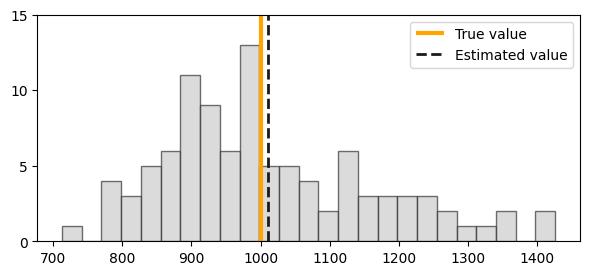

In [16]:
B = 100  # Number of iterations
N = 1000  # True size of the network

nodes = list(range(N))  

# Array to store network size estimates
N_est = np.zeros(B)

### Perform capture-recapture simulation
for b in range(B):
    # Randomly sample the size of the first and second sample sets
    n1 = np.random.randint(150, 200)
    n2 = np.random.randint(150, 200)
    
    # Randomly select nodes for the first and second samples
    V_s1 = np.random.choice(nodes, size=n1, replace=False)
    V_s2 = np.random.choice(nodes, size=n2, replace=False)
    
    # Count the number of nodes in the intersection (recaptured nodes)
    n_c = len(set(V_s1).intersection(V_s2))
    
    # Estimate the network size if recaptured nodes exist; otherwise, set to NaN
    N_est[b] = n1 * n2 / n_c if n_c > 0 else np.nan


# Filter out invalid estimates (NaN values)
N_est = N_est[np.isfinite(N_est)]

#################

fig, ax = plt.subplots(1, 1, figsize=(7, 3), dpi=100)
ax.hist(N_est, bins=25, color='.8', edgecolor='.2', alpha=0.7)
ax.vlines(N, 0, 15, linewidth=3, label='True value', color='orange')

mu = np.mean(N_est)
ax.vlines(mu, 0, 15, color='.1', linewidth=2, label='Estimated value', linestyle='--')

ax.legend()
ax.set_yticks(range(0,25,5))
ax.set_ylim(0, 15)

plt.show()

In [17]:
N = 10000

frac = [0.01, 0.05, 0.1, 0.2]
n_iter = 100
for f in frac:
    est = []
    for _ in range(n_iter):
        n1 = int(np.random.normal(f*N, 2))
        n2 = int(np.random.normal(f*N, 2))

        sample1 = np.random.choice(list(range(N)), n1, replace=False)
        sample2 = np.random.choice(list(range(N)), n2, replace=False)

        est.append(len(set(sample1).intersection(sample2)))
        
    print("frac =",f, "\tsampled set size = %.2f"%np.mean(est), "\tnetwork size estimate = %.2f"%(n1*n2/np.mean(est)))

frac = 0.01 	sampled set size = 1.05 	network size estimate = 9522.86
frac = 0.05 	sampled set size = 24.60 	network size estimate = 10000.61
frac = 0.1 	sampled set size = 99.63 	network size estimate = 10027.08
frac = 0.2 	sampled set size = 402.49 	network size estimate = 9953.05


_________
## Method 2: Incident Subgraph Sampling
![](images/incident_subgraph_sampling.png)

***Incident subgraph sampling*** involves drawing $n$ *edges* at random from a graph of size $N$. Let us denote with $G = (V,E)$ the original graph and with $G_s = (V_s,E_s)$ the sampled subgraph. Then, the set $E_s$ includes the $n$ edges randomly selected from $E$ and $V_s$ contains all the nodes incident to the selected edges such that $\forall e_{i,j} \in E_s$, $i,j \in V_s$.

In this case, the _vertex inclusion probability_ is equal to:
$$ \pi_i =   \begin{cases} 1 - \frac{\binom{N_e - k_i}{n}}{\binom{N_e}{n}}, \text{ if } n\leq N_e - k_i\\ 
1, \text{ if } n > N_e - k_i \end{cases} $$
while the _edge inclusion probability_ is equal to:
$$ \pi_{e_{i,j}} = \frac{n}{N_e} ,$$

$\forall i \in V$, and $\forall e_{i,j} \in E$.

Notice that $\pi_i$ is computed as one minus the probability of __not__ sampling an edge incident to $i$.

In [18]:
from random import shuffle

def incident_subgraph_sampling(G, n, is_directed=False):
    """
    Samples an incident subgraph containing `n` edges from the input graph `G`.
    
    Parameters
    ----------
    G : networkx.Graph or networkx.DiGraph
        The input graph from which the subgraph is sampled.
    n : int
        The number of edges to include in the sampled incident subgraph.
    is_directed : bool, optional (default=False)
        Specifies if the graph is directed. If True, edges are treated as directed.
        
    Returns
    -------
    subgraph : networkx.Graph or networkx.DiGraph
        The incident subgraph with `n` edges and the nodes connected by those edges.
        
    Raises
    ------
    ValueError
        If `n` is larger than the number of edges in the graph.
    """
    # Ensure `n` is not larger than the number of edges in G
    if n > G.number_of_edges():
        raise ValueError("`n` must be less than or equal to the number of edges in the graph.")
    
    # Get the list of edges in the graph
    edges = list(G.edges())
    
    # Shuffle the edges randomly to sample from them
    shuffle(edges)
    
    # Select the first `n` edges from the shuffled list
    sampled_edges = edges[:n]
    
    # Find the unique nodes connected by the sampled edges
    sampled_nodes = set(node for edge in sampled_edges for node in edge)
    
    # Create a new subgraph with the sampled nodes and edges
    subgraph = G.edge_subgraph(sampled_edges).copy()
    
    return subgraph

### Let's look at an example where we randomly assign nodes to group labels in a network

Is our approach able to correctly estimate the proportion of red/blue nodes?

In [19]:
N = 1000
G = nx.barabasi_albert_graph(N,10)
pos = nx.spring_layout(G)
print("Average degree: %1.1f" % np.mean(list(dict(G.degree()).values())))
M = G.number_of_edges()
print("Number of edges:", M)

Average degree: 19.8
Number of edges: 9900


In [20]:
prob_red = 0.7
reds = 0
blues = 0
for node in G.nodes():
    G.nodes[node]['team'] = 'red' if np.random.rand() < prob_red else 'blue'
    if G.nodes[node]['team'] == 'red':
        reds += 1
    else:
        blues += 1
        
print("Number of red nodes:",reds)
print("Number of blue nodes:",blues)

Number of red nodes: 713
Number of blue nodes: 287


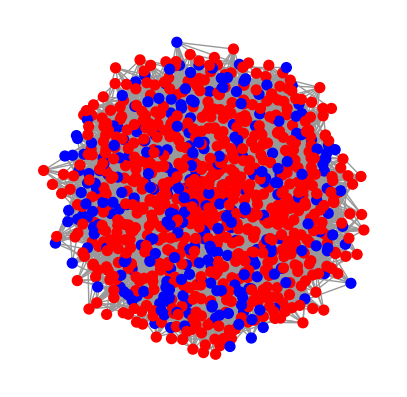

In [21]:
fig, ax = plt.subplots(1,1,figsize=(5,5),dpi=100)
nx.draw(G, pos=pos, node_color=nx.get_node_attributes(G, 'team').values(),ax=ax,node_size=50, edge_color='.6')
plt.show()

In [22]:
from scipy.special import binom

def prob_i(N_e, k_i, n):
    """
    Calculate the probability of at least one sample overlapping with node i.

    Parameters:
    N_e : int
        Effective size of the network.
    k_i : int
        Number of samples that do not include node i.
    n : int
        Number of nodes in the sample.

    Returns:
    float
        Probability of at least one sample overlapping with node i.
    """
    # If the sample size exceeds the available nodes excluding k_i, 
    # the probability is 1 (certain inclusion).
    if n > N_e - k_i:
        return 1.0
    
    # Otherwise, calculate the complement of the probability that node i is not sampled.
    return 1.0 - binom(N_e - k_i, n) / binom(N_e, n)

In [23]:
# We use the Horovitz-Thompson estimator to get those numbers from sampled graphs
B = 1000
reds_est = [None]*B
blues_est = [None]*B
degrees = dict(G.degree())

for b in range(B):
    n = 100
    G_s = incident_subgraph_sampling(G,n)
    V_s = list(G_s.nodes())
    E_s = list(G_s.edges())
    pi = {node: prob_i(M,degrees[node],n)  for node in V_s}
    reds_est[b] = sum([ 1.0/pi[node] for node in V_s if G.nodes[node]['team'] == 'red'])
    blues_est[b] = sum([ 1.0/pi[node] for node in V_s if G.nodes[node]['team'] == 'blue'])

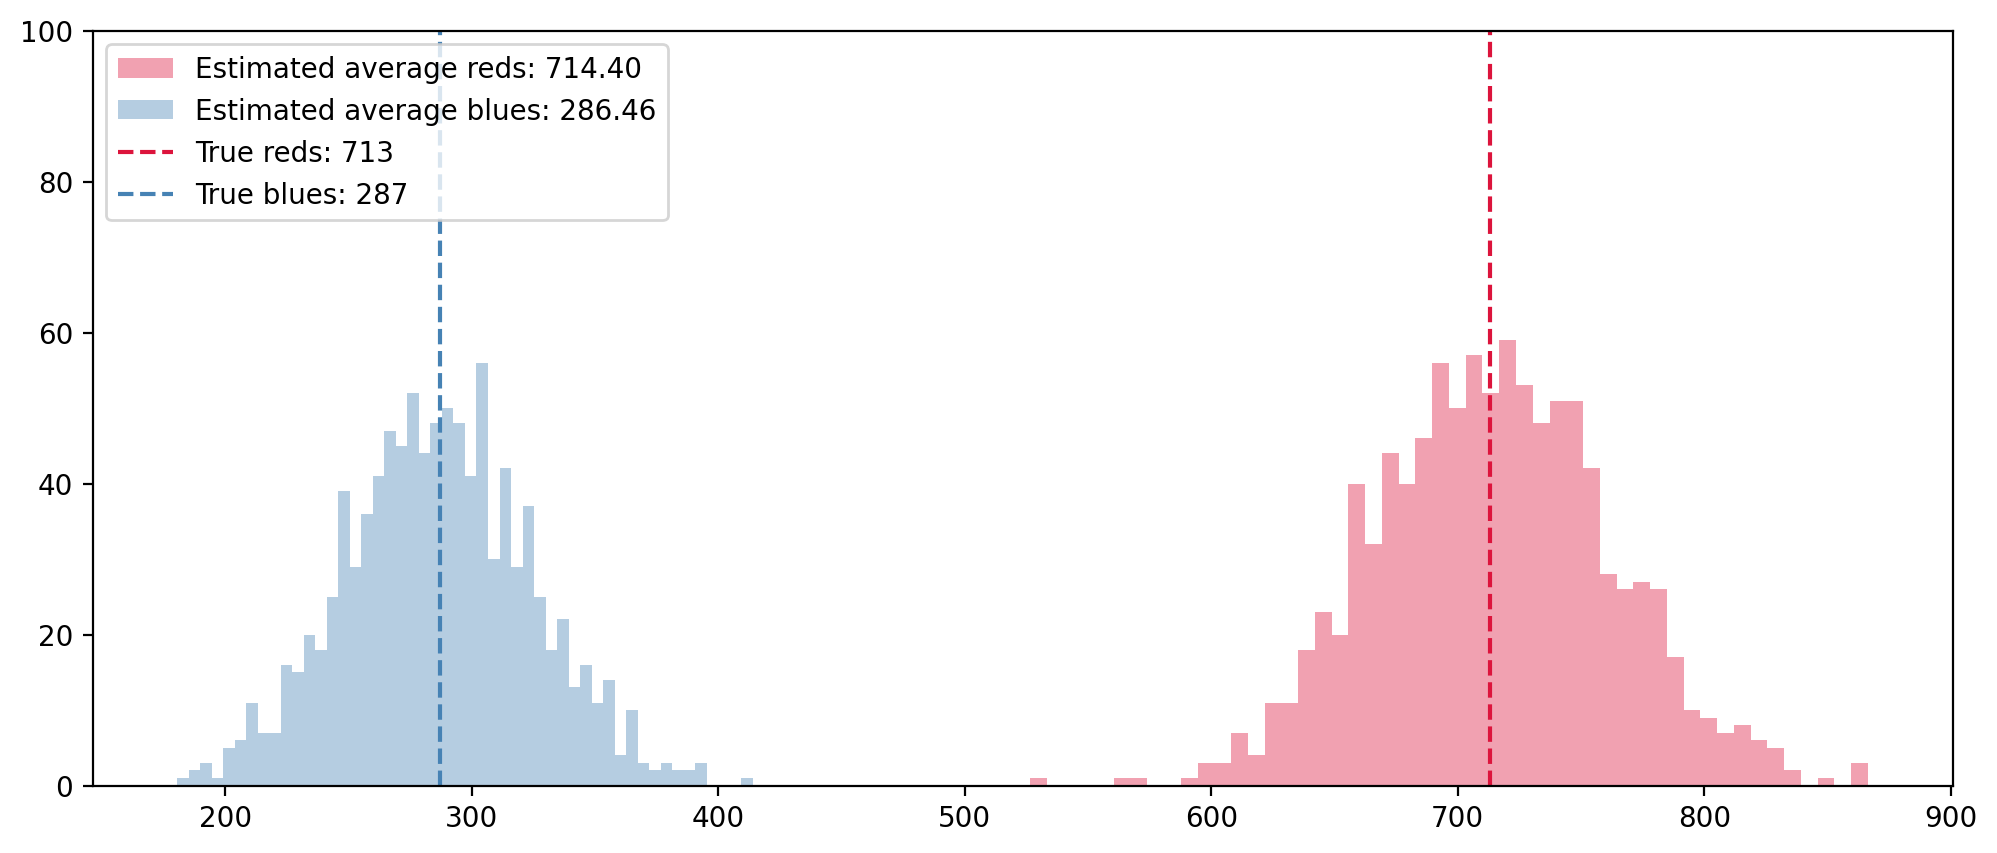

In [24]:
fig, ax = plt.subplots(1,1,figsize=(12,5),dpi=200)

ax.hist(reds_est, bins=50, color='crimson', alpha=0.4,
        label='Estimated average reds: %.2f'%(np.mean(reds_est)))
ax.hist(blues_est, bins=50, color='steelblue', alpha=0.4,
        label='Estimated average blues: %.2f'%(np.mean(blues_est)))

ax.vlines(reds, 0, 100, color='crimson', ls='--', label='True reds: %i'%reds)
ax.vlines(blues, 0, 100, color='steelblue', ls='--', label='True blues: %i'%blues)

ax.legend(loc=2)
ax.set_ylim(0,100)

plt.show()

In [25]:
N = 10000
M = 50000
G = nx.gnm_random_graph(N,M)
degrees = list(dict(G.degree()).values())
print("Average degree: %1.3f" % np.mean(degrees))
n = 5000

Average degree: 10.000


In [26]:
# Using Incident Graph Sampling
G_incid = incident_subgraph_sampling(G, n)
degrees_incid = list(dict(G_incid.degree()).values())
x_incid, y_incid = get_binning(degrees_incid, log_binning=True, is_pmf=True, num_bins=15)

In [27]:
# True Degree distribution
x_true, y_true = get_binning(degrees, log_binning=True, is_pmf=True, num_bins=15)

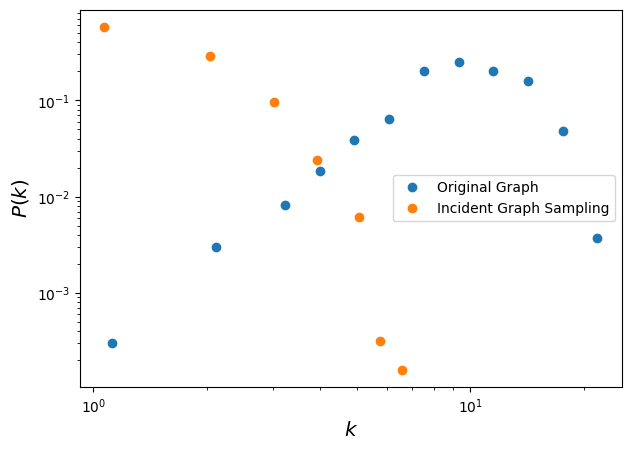

In [28]:
fig, ax = plt.subplots(1,1,figsize=(7,5),dpi=100)
ax.loglog(x_true,y_true,'o', label='Original Graph')
ax.loglog(x_incid, y_incid, 'o', label='Incident Graph Sampling')
ax.legend()
ax.set_xlabel(r'$k$',fontsize='x-large')
ax.set_ylabel(r'$P(k)$',fontsize='x-large')

plt.show()

__________
## Edge Sampling with Graph Induction (ES-i)
![](images/ES-i.png)

***Edge Sampling with Graph Induction*** consists in drawing at random $n$ edges from a graph of size $N$. Let us denote with $G = (V,E)$ the original graph and with $G_s = (V_s,E_s)$ the sampled subgraph. Then, $V_s$ contains all the nodes incident to the randomly selected edges and $E_s$ comprises the $n$ edges randomly selected from $E$ plus all the other edges $e_{i,j} \in E$ such that that both $i$ and $j$ belong to $V_s$. 

Some observations: 

1. Edge sampling is inherently biased towards selection of nodes with higher degrees resulting in an upward bias in the degree distributions of sampled nodes compared to nodes in the original graph.
2. In sampled subgraphs degrees are naturally underestimated since only a fraction of neighbors may be selected. This results in a downward bias, regardless of the actual sampling algorithm used.
3. The upward bias of edge sampling can help offset this downward bias to some extent, it alone is not sufficient to fully offset the bias.
4. Then, a simple graph induction step over the edge-sampled node set (where we sample all the edges between any sampled nodes in the graph) can recover much of the connectivity around the high degree nodes offsetting the downward degree bias as well as improving local clustering in the sampled graph.

In [29]:
def edge_sampling_with_induction(G, n):
    """
    Perform edge sampling with induction and return a new graph.

    Parameters:
    G : networkx.Graph
        Input graph.
    n : int
        Number of edges to sample initially.

    Returns:
    networkx.Graph
        A new graph induced by the sampled nodes and edges.
    """
    # Get all edges and total number of edges in the graph
    edges = list(G.edges())
    M = G.number_of_edges()
    
    # Sample n edges randomly without replacement
    sampled_edges = set([edges[i] for i in np.random.permutation(M)[:n]])
    
    # Extract the set of nodes in the sampled edges
    nodes_from_sampled_edges = set(node for edge in sampled_edges for node in edge)
    
    # Induce edges between the sampled nodes
    induced_edges = set(sampled_edges)
    for node_i, node_j in edges:
        if node_i in nodes_from_sampled_edges and node_j in nodes_from_sampled_edges:
            induced_edges.add((node_i, node_j))
    
    # Create a new graph with the sampled nodes and induced edges
    new_graph = nx.Graph()
    new_graph.add_nodes_from(nodes_from_sampled_edges)
    new_graph.add_edges_from(induced_edges)
    
    return new_graph

In [30]:
G_esi = edge_sampling_with_induction(G, n)
degrees_esi = list(dict(G_esi.degree()).values())
x_esi,y_esi = get_binning(degrees_esi, log_binning=True, is_pmf=True, num_bins=15)

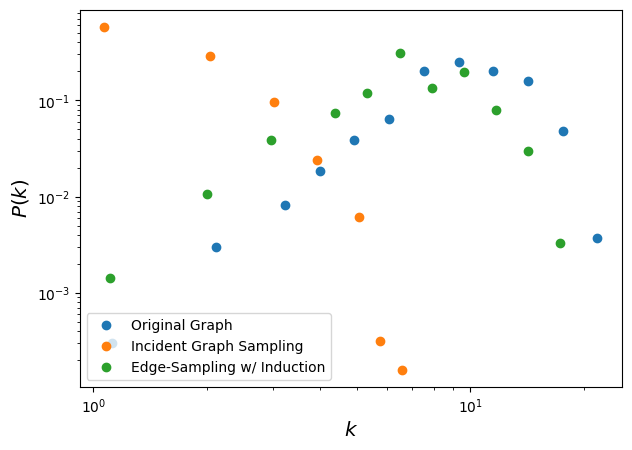

In [31]:
fig, ax = plt.subplots(1,1,figsize=(7,5),dpi=100)
ax.loglog(x_true, y_true, 'o', label='Original Graph')
ax.loglog(x_incid, y_incid, 'o', label='Incident Graph Sampling')
ax.loglog(x_esi, y_esi, 'o', label='Edge-Sampling w/ Induction')
ax.legend()
ax.set_xlabel(r'$k$',fontsize='x-large')
ax.set_ylabel(r'$P(k)$',fontsize='x-large')


plt.show()

In [32]:
N = 10000
ba = nx.barabasi_albert_graph(N, 5)
degrees = np.array(list(dict(ba.degree()).values()))
print("Average degree: %1.3f" % np.mean(degrees))
M = ba.number_of_edges()
n = int(M*0.15)

Average degree: 9.995


In [33]:
# Using Edge Sampling with Graph Induction
ba_s = edge_sampling_with_induction(ba,n)
V_s, E_s = ba_s.number_of_nodes(), ba_s.number_of_edges()
degrees_s = np.array(list(dict(ba_s.degree()).values()))

x_s,y_s = get_binning(degrees_s, log_binning=True, is_pmf=True, num_bins=15)

In [34]:
# Using Incident Graph Sampling
ba_s_i = incident_subgraph_sampling(ba,n)
V_s_i, E_s_i = ba_s_i.number_of_nodes(), ba_s_i.number_of_edges()
degrees_s_i = np.array(list(dict(ba_s_i.degree()).values()))

x_s_i,y_s_i = get_binning(degrees_s_i, log_binning=True, is_pmf=True, num_bins=15)

In [35]:
# True Degree distribution
x_t,y_t = get_binning(degrees, log_binning=True, is_pmf=True, num_bins=15)

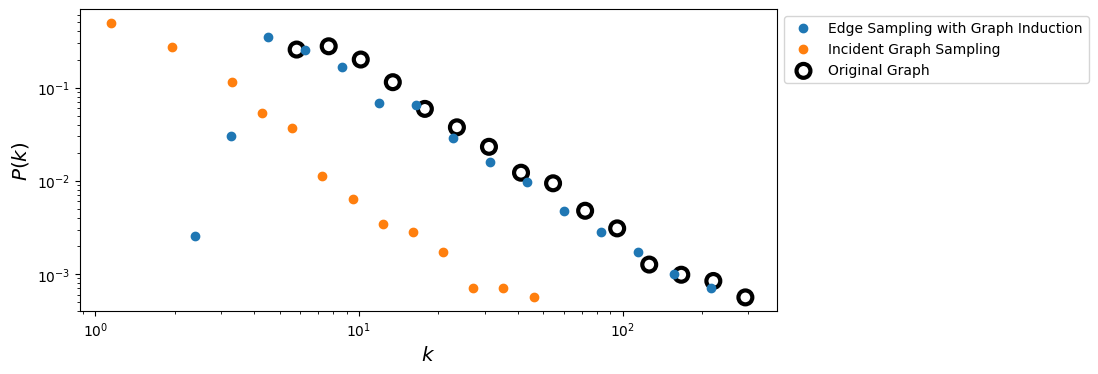

In [36]:

fig, ax = plt.subplots(1,1,figsize=(9,4),dpi=100)
ax.loglog(x_s,y_s,'o', label = 'Edge Sampling with Graph Induction')
ax.loglog(x_s_i,y_s_i,'o', label = 'Incident Graph Sampling')
ax.scatter(x_t,y_t, s= 100, facecolors='none', edgecolors='k',lw=3, label = 'Original Graph')

ax.legend(loc=2,bbox_to_anchor=[1.0,1.0])
ax.set_xlabel(r'$k$',fontsize='x-large')
ax.set_ylabel(r'$P(k)$',fontsize='x-large')


plt.show()

____________
## Method 3: Snowball Sampling
![](images/snowball_sampling.png)

***Snowball sampling*** consists of drawing at random $n$ nodes from a graph of size $N$. Let's denote this initial set of nodes with $V_{s,0}$ and with $\mathbb{V}(S)$ the set of all neighbors of the vertices in the a given set $S$. Then, a $k$-wave snowball sampling algorithm simply extends the initial set of nodes $V_{s,0}$ $k$ times in the following way:
* $V_{s,1} = \mathbb{V}(V_{s,0}) \cap \bar{V}_{s,0}$, 
* $V_{s,2} = \mathbb{V}(V_{s,1}) \cap \bar{V}_{s,1} \cap \bar{V}_{s,0}$, 
* ...
* $V_{s,k} = \mathbb{V}(V_{s,k-1}) \cap \bar{V}_{s,k-1} \cap \dots \cap \bar{V}_{s,0}$. 

1. When the degree distribution of the original network is power-law, it is found that the estimated degree exponent decreases with snowball sampling as we decrease the sampling fraction. 
2. Sampled networks are shown to be more disassortative than the original networks. This pattern is common no matter whether the original network is assortative, disassortative, or neutral.

In [68]:
def snowball_sampling(G, seed_nodes, n_waves=2):
    """
    Perform snowball sampling on a graph.

    Parameters:
    G : networkx.Graph or networkx.DiGraph
        Input graph.
    seed_nodes : list or set
        Initial set of nodes to start the snowball sampling.
    n_waves : int, optional
        Number of waves to expand the snowball sampling (default is 2).

    Returns:
    networkx.Graph or networkx.DiGraph
        A new graph G_s containing the sampled nodes and edges.
    """
    # Initialize sets to keep track of sampled nodes and edges
    V_s = set(seed_nodes)
    E_s = set()
    
    # Initialize the wave structure
    V = [set()] * (n_waves + 1)
    V[0] = set(seed_nodes)
    
    # Perform snowball sampling over the specified number of waves
    for k in range(n_waves):
        V[k + 1] = set()  # Initialize the next wave
        for node_i in V[k]:
            for node_j in G.neighbors(node_i):
                # Add the edge to the sampled edge set
                edge = (node_i, node_j) if not G.is_directed() and node_i < node_j else (node_i, node_j)
                E_s.add(edge)
                
                # Add the neighboring node to the next wave
                V[k + 1].add(node_j)
        
        # Exclude nodes already in the sampled set
        V[k + 1] -= V_s
        
        # Add new nodes to the sampled set
        V_s.update(V[k + 1])
    
    # Create the new sampled graph
    G_s = G.subgraph(V_s).copy()

    return G_s

In [69]:
N = 15000
m = 3
G = nx.barabasi_albert_graph(N, m)
M = G.number_of_nodes()
degrees = list(dict(G.degree()).values())
print(M)

15000


Number of waves: 0 | Number of nodes discovered: 50 | Number of edges discovered: 0
Number of waves: 1 | Number of nodes discovered: 447 | Number of edges discovered: 554
Number of waves: 2 | Number of nodes discovered: 3529 | Number of edges discovered: 7416
Number of waves: 3 | Number of nodes discovered: 13769 | Number of edges discovered: 40762
Number of waves: 4 | Number of nodes discovered: 15000 | Number of edges discovered: 44991
Number of waves: 5 | Number of nodes discovered: 15000 | Number of edges discovered: 44991


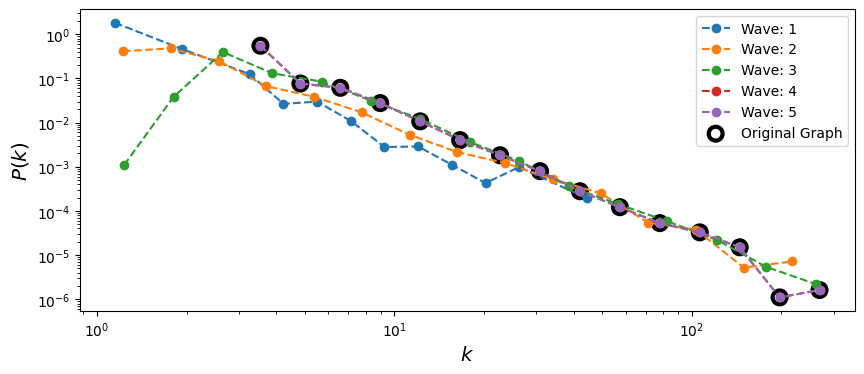

In [71]:
fig, ax = plt.subplots(1,1,figsize=(10, 4), dpi=100)

n = 50  # Number of seed nodes
n_waves = 5  # Maximum number of waves
degrees_sampled = [None] * (n_waves + 1)

nodes = list(G.nodes())

# Perform snowball sampling for increasing numbers of waves
for k in range(n_waves + 1):
    # Select seed nodes randomly
    seed_nodes = set(np.random.choice(nodes, size=n, replace=False))
    
    # Perform snowball sampling
    G_s = snowball_sampling(G, seed_nodes, n_waves=k)
    
    # Print summary of the sampled graph
    print(f"Number of waves: {k} | Number of nodes discovered: {G_s.number_of_nodes()} | "
          f"Number of edges discovered: {G_s.number_of_edges()}")
    
    # Get degree distribution of the sampled graph
    degrees_sampled[k] = [deg for _, deg in G_s.degree()]
    
    # Plot degree distribution for the current wave
    if k > 0:
        x1, y1 = get_binning(degrees_sampled[k], log_binning=True, num_bins=15, is_pmf=False)
        ax.loglog(x1, y1, '--o', label=f'Wave: {k}')

# Plot the degree distribution of the original graph
x, y = get_binning(degrees, log_binning=True, num_bins=15, is_pmf=False)
ax.scatter(x, y, s=100, facecolors='none', edgecolors='k', lw=3, label='Original Graph')

ax.legend()
ax.set_xlabel(r'$k$',fontsize='x-large')
ax.set_ylabel(r'$P(k)$',fontsize='x-large')


plt.show()

_____________
## Method 4: Traceroute Sampling
![](images/traceroute_sampling.png)

***Traceroute sampling*** is an example of a _link tracing_ algorithm used to generate sampled graphs. In traceroute sampling, two initial disjoint sets of nodes are drawn at random: a set of _sources_ $V_S$ of size $n_S$ and a set of _targets_ $V_T$ of size $n_T$. Then, a route is traced from each node in $V_S$ to each node in $V_T$ and all vertices and edges encountered are added to $V_s$ and $E_s$, respectively.  Then, the sampled graph is $G_s = (V_s,E_s)$.

If the source and target sets are obtained using a simple random sampling without replacement and the route considered is simply the shortest path between each pair of vertices, then the _vertex inclusion probability_ can be approximated with:
$$ \pi_i \approx 1 - \left(1 - \frac{n_S}{N_v} - \frac{n_T}{N_v}\right)\exp\left(-b_i\frac{n_S}{N_v}\frac{n_T}{N_v}\right)  ;$$
while the _edge inclusion probability_ can be approximated with:
$$ \pi_{e_{i,j}} \approx 1 - \exp\left(-b_{e_{i,j}}\frac{n_S}{N_v}\frac{n_T}{N_v}\right) ;$$
where $b_i$ is the betweenness centrality of vertex $i$ and $b_{e_{i,j}}$ is the betweenness centrality of edge $e_{i,j}$. 

1. Traceroute sampling can make power laws appear where none existed in the underlying graph (even in the extreme case of regular random graphs)
2. Even when the original degree distribution is power-law, traceroute sampling significantly underestimate the tail exponent

In [50]:
def traceroute_sampling(G, n_sources=5, n_targets=50):
    """
    Perform traceroute sampling on a graph, selecting multiple sources and targets.

    Parameters:
    G : networkx.Graph
        Input graph.
    n_sources : int, optional
        Number of source nodes (default is 5).
    n_targets : int, optional
        Number of target nodes (default is 50).

    Returns:
    networkx.Graph
        A new graph containing the sampled nodes and edges.
    """
    nodes = list(G.nodes())
    shuffle(nodes)

    # Select sources and targets
    sources = set(nodes[:n_sources])
    targets = set(nodes[n_sources:n_sources + n_targets])

    # Initialize the sampled graph
    G_s = nx.Graph() if not G.is_directed() else nx.DiGraph()

    # Compute shortest paths from each source to each target
    for source_node in sources:
        for target_node in targets:
            try:
                path = nx.shortest_path(G, source=source_node, target=target_node)
                G_s.add_nodes_from(path)
                G_s.add_edges_from((path[i], path[i + 1]) for i in range(len(path) - 1))
            except nx.NetworkXNoPath:
                pass  # Ignore if no path exists

    return G_s

In [51]:
N = 2000
k = 15.0
G = nx.erdos_renyi_graph(N, k/(N-1))
degrees = list(dict(G.degree()).values())
M = G.number_of_edges()

G_s_t = traceroute_sampling(G, n_sources=2, n_targets=3)

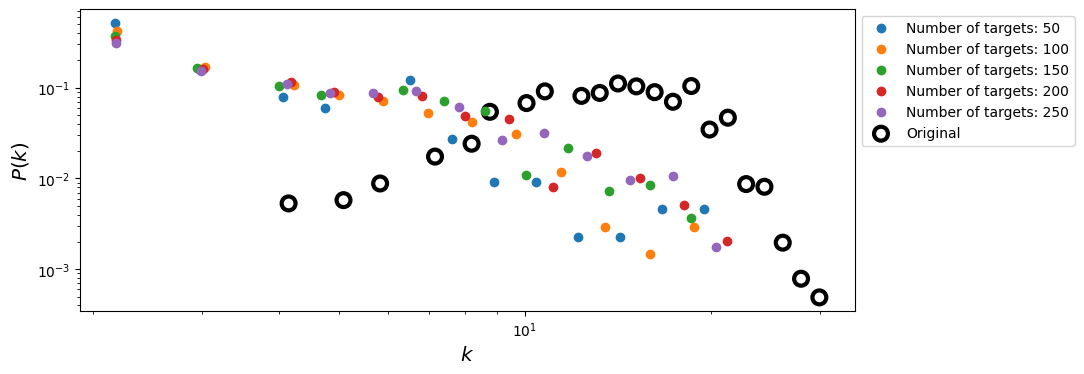

In [52]:
n_sources = 8
share_nodes = []
share_edges = []
sampled_degrees = []

N_targets = np.arange(50,261,50)
for n_targets in N_targets:
    G_s = traceroute_sampling(G, n_sources, n_targets)
    share_nodes.append(G_s.number_of_nodes()/N)
    share_edges.append(G_s.number_of_edges()/M)

    degrees_s = list(dict(G_s.degree()).values())
    
    sampled_degrees.append(degrees_s)

fig, ax = plt.subplots(1,1,figsize=(10, 4), dpi=100)
for k, values in enumerate(sampled_degrees):
    x,y = get_binning(values, log_binning=True, num_bins=15, is_pmf=True)
    ax.loglog(x,y, 'o', label = "Number of targets: %d" % N_targets[k])

x,y = get_binning(degrees, log_binning=True, num_bins=30, is_pmf=False)
ax.scatter(x,y, s= 100, facecolors='none', edgecolors='k',lw=3,label = "Original")
    
ax.legend(loc=2,bbox_to_anchor=[1.0,1.0])
ax.set_xlabel(r'$k$',fontsize='x-large')
ax.set_ylabel(r'$P(k)$',fontsize='x-large')


plt.show()

____________
### Bias reduction in Traceroute Sampling

We can use the _capture-recapture_ estimator to improve the sampled degree distribution (from Flaxman & Vera, 2007). 

Let us denote with $U$ the set of sources we are using to perform the traceroute sampling and with $G_{u_1}$ and $G_{u_2}$ two sampled graphs obtained using source nodes $u_1$ and $u_2$, respectively. Then, we can estimate the degree of a generic node $i$ in the sampled graph $G_{u_1}$ as:

$$ \hat{k}(i)_{u_1,u_2} = \begin{cases} \frac{|V_{u_1}(i)|\times |V_{u_2}(i)|}{|V_{u_1}(i)\cap V_{u_2}(i)|}, & \mbox{if } \left|V_{u_1}(i)\cap V_{u_2}(i)\right|>2 \\ 
\infty, & \mbox{otherwise. } \end{cases} $$

Then, we can repeat the same procedure for all the pairs of sources in $U$ and obtain the final estimate for the degree of node $i$ as:

$$ \hat{k}(i) = median \left( \left\{ \hat{k}(i)_{u_i,u_j} \neq \infty  \right\} \right) $$

**Source:** Flaxman, A. D., & Vera, J. (2007). Bias reduction in traceroute sampling–towards a more accurate map of the internet. In International Workshop on Algorithms and Models for the Web-Graph (pp. 1-15). Berlin, Heidelberg: Springer Berlin Heidelberg. https://link.springer.com/chapter/10.1007/978-3-540-77004-6_1

In [53]:
from collections import defaultdict
from itertools import combinations

def bias_reduction(sampling_method, num_samples, args):
    """
    sampling_method(**args) should return a NetworkX graph G_s
    for each sample (e.g., traceroute sample from some source set).
    """
    # Draw samples (each is a NetworkX graph)
    samples = [sampling_method(**args) for _ in range(num_samples)]
    degrees = defaultdict(list)

    # Pair up samples: first half vs second half
    # (num_samples should be even for this scheme)
    pairs = list(zip(samples[:num_samples // 2], samples[num_samples // 2:]))

    # If you prefer all pairs, use: pairs = combinations(samples, 2)
    for G_s1, G_s2 in pairs:
        # For each node in first sampled graph
        for u in G_s1.nodes():
            if u in G_s2:
                # Neighbors in each sampled graph
                neigh1 = set(G_s1.neighbors(u))
                neigh2 = set(G_s2.neighbors(u))

                N_c = len(neigh1.intersection(neigh2))
                if N_c > 2:
                    # capture–recapture estimator for k(u)
                    degrees[u].append(len(neigh1) * len(neigh2) / N_c)

    # Median estimate per node
    degrees_est = [np.median(values) for node, values in degrees.items()]

    return degrees_est


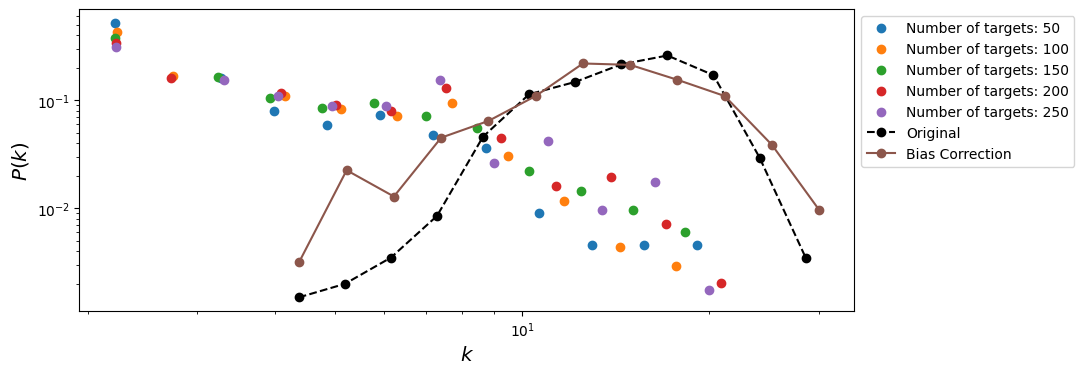

In [54]:
n_sources = 10
n_targets = 150
n_samples = 10

args = {'G':G,'n_sources':n_sources,'n_targets':n_targets}

G_s = traceroute_sampling(G,n_sources,n_targets)
degrees_s = list(dict(G_s.degree()).values())


fig, ax = plt.subplots(1,1,figsize=(10, 4), dpi=100)

# k = N_targets[2]
# values = sampled_degrees[2]
for k, values in enumerate(sampled_degrees):
    x,y = get_binning(values, log_binning=True, num_bins=12, is_pmf = True)
    ax.loglog(x,y, 'o', label = "Number of targets: %d" % N_targets[k])

degrees_est = bias_reduction(traceroute_sampling, n_samples, args)
    
x,y = get_binning(degrees, log_binning=True, num_bins=12, is_pmf = True)
ax.loglog(x,y, '--o', color='k', label = "Original")

x,y = get_binning(degrees_est, log_binning=True, num_bins=12, is_pmf = True)
ax.loglog(x,y, '-o', label = "Bias Correction")



ax.legend(loc=2,bbox_to_anchor=[1.0,1.0])
ax.set_xlabel(r'$k$',fontsize='x-large')
ax.set_ylabel(r'$P(k)$',fontsize='x-large')


plt.show()

There are many more ways to imagine debiasing the sampling procedure!

__________
## Next time...
Link Prediction `class_23_linkprediction.ipynb`
_______

## References and further resources:

1. Class Webpages
    - Jupyter Book: https://network-science-data-and-models.github.io/phys7332_fa25/README.html
    - Github: https://github.com/network-science-data-and-models/phys7332_fa25/
    - Syllabus and course details: https://brennanklein.com/phys7332-fall25
2. Achlioptas, D., Clauset, A., Kempe, D., & Moore, C. (2009). On the bias of traceroute sampling: Or, power-law degree distributions in regular graphs. Journal of the ACM (JACM), 56(4), 21.f Traceroute Sampling. In STOC, ACM (Vol. 1581139608, No. 05, p. 0005).
3. Ahmed, N. K., Neville, J., & Kompella, R. (2014). Network sampling: From static to streaming graphs. ACM Transactions on Knowledge Discovery from Data (TKDD), 8(2), 7.
4. Dall'Asta, L., Alvarez-Hamelin, I., Barrat, A., Vazquez, A., & Vespignani, A. (2004). A statistical approach to the traceroute-like exploration of networks: theory and simulations. arXiv preprint cond-mat/0406404.
5. Flaxman, A. D., & Vera, J. (2007). Bias Reduction in Traceroute Sampling–Towards a More Accurate Map of the Internet. In Algorithms and Models for the Web-Graph (pp. 1-15). Springer Berlin Heidelberg.
6. Gjoka, M., Kurant, M., Butts, C. T., & Markopoulou, A. (2010, March). Walking in Facebook: A case study of unbiased sampling of OSNs. In INFOCOM, 2010 Proceedings IEEE (pp. 1-9). IEEE.
7. Leskovec, J., & Faloutsos, C. (2006, August). Sampling from large graphs. In Proceedings of the 12th ACM SIGKDD international conference on Knowledge discovery and data mining (pp. 631-636). ACM.
8. Leskovec, J., Kleinberg, J., & Faloutsos, C. (2005, August). Graphs over time: densification laws, shrinking diameters and possible explanations. In Proceedings of the eleventh ACM SIGKDD international conference on Knowledge discovery in data mining (pp. 177-187). ACM.
9. Lovász, L. (1996). Random walks on graphs: A survey. Combinatorics, Paul Erdos is Eighty, 2, 353-398.
10. Kolaczyk, E. (2009). Statistical Analysis of Network Data: Methods and Models. Springer Series in Statistics.